In [1]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml

MAX_JETS = 6
PLOTS_DIR = f"plots/compare_model_performance/"
CONFIG_PATH = "../config/workspace_config_high_level_features.yaml"

import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
plt.rcParams.update({"font.size": 14})

load_config = get_load_config_from_yaml(CONFIG_PATH)

DataProcessor = DataPreprocessor(load_config)
with open(CONFIG_PATH, "r") as f:
    data_config = yaml.safe_load(f)

data_config = DataProcessor.load_from_npz(data_config["npz_datapath"]["nominal"],max_events=100000)
X_train, y_train, X_val, y_val = DataProcessor.split_data(test_size=0.99)

2025-11-20 14:29:26.597332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763645366.619456 3100938 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763645366.626905 3100938 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763645366.644347 3100938 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763645366.644365 3100938 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763645366.644368 3100938 computation_placer.cc:177] computation placer alr

In [2]:
import core.assignment_models as AssignmentModels
import core.reconstruction as Evaluation

reload(Evaluation)
reload(AssignmentModels)

ToponiumTransformer = AssignmentModels.FeatureConcatTransformer(data_config, name="ToponiumTransformer")
MODEL_DIR = f"models/toponium_transformer_high_level_features/"
ToponiumTransformer.load_model(MODEL_DIR + "model.keras")

Transformer = AssignmentModels.FeatureConcatTransformer(data_config, name="Transformer")
MODEL_DIR = f"models/assignment_transformer_high_level_features/"
Transformer.load_model(MODEL_DIR + "model.keras")



FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.


I0000 00:00:1763645438.946872 3100938 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Model loaded from models/toponium_transformer_high_level_features/model.keras
Training history loaded from models/toponium_transformer_high_level_features/model_history.npz
FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.
Model loaded from models/assignment_transformer_high_level_features/model.keras
Training history loaded from models/assignment_transformer_high_level_features/model_history.npz


/data/dust/group/atlas/ttreco/venv/lib64/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 218 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
evaluator = Evaluation.ReconstructionEvaluator(
    [
        #AssignmentModels.DeltaRAssigner(data_config),
        AssignmentModels.ChiSquareAssigner(data_config, top_mass=173.5e3),
        Evaluation.GroundTruthReconstructor(data_config, name="Ground Truth"),
        ToponiumTransformer,
        Transformer,
    ],
    X_val,
    y_val,
)

I0000 00:00:1763645443.284774 3102840 service.cc:152] XLA service 0x7f788801d1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763645443.284801 3102840 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-11-20 14:30:43.342334: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-20 14:30:43.370737: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763645443.643096 3102840 cuda_dnn.cc:529] Loaded cuDNN version 91500
I0000 00:00:1763645444.597211 3102840 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-20 14:30:47.433905: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring


Computing bootstrap confidence intervals...
$\chi^2$-Method ($\nu^2$-Flows): 0.6077 [0.6044, 0.6107]
Ground Truth: Ground Truth (skipping)
ToponiumTransformer: 0.2391 [0.2361, 0.2416]
Transformer: 0.8076 [0.8052, 0.8100]


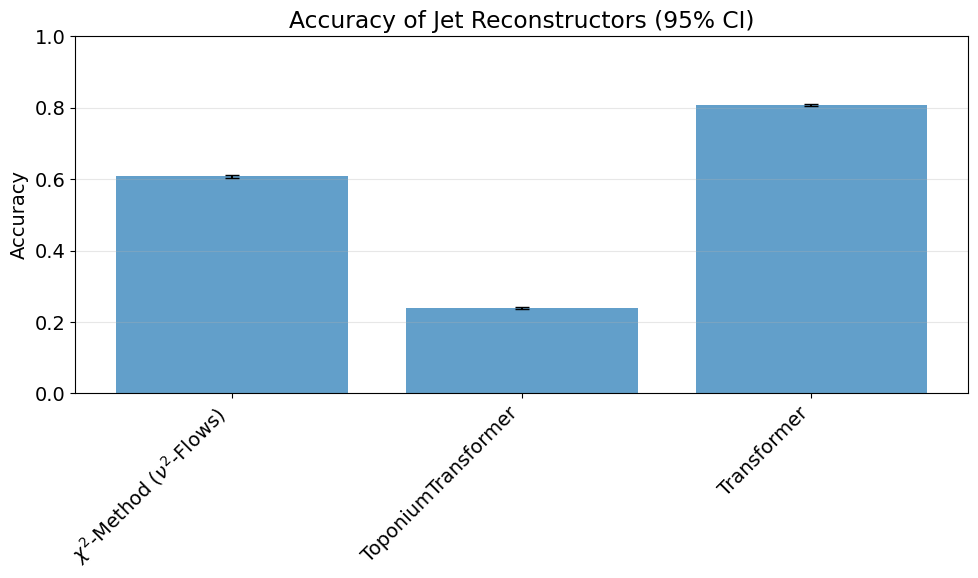

In [4]:
fig, ax = evaluator.plot_all_accuracies()
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")


Computing bootstrap confidence intervals...
$\chi^2$-Method ($\nu^2$-Flows): 0.7526 [0.7504, 0.7551]
Ground Truth: Ground Truth (skipping)
ToponiumTransformer: 0.8593 [0.8573, 0.8613]
Transformer: 0.9540 [0.9528, 0.9553]


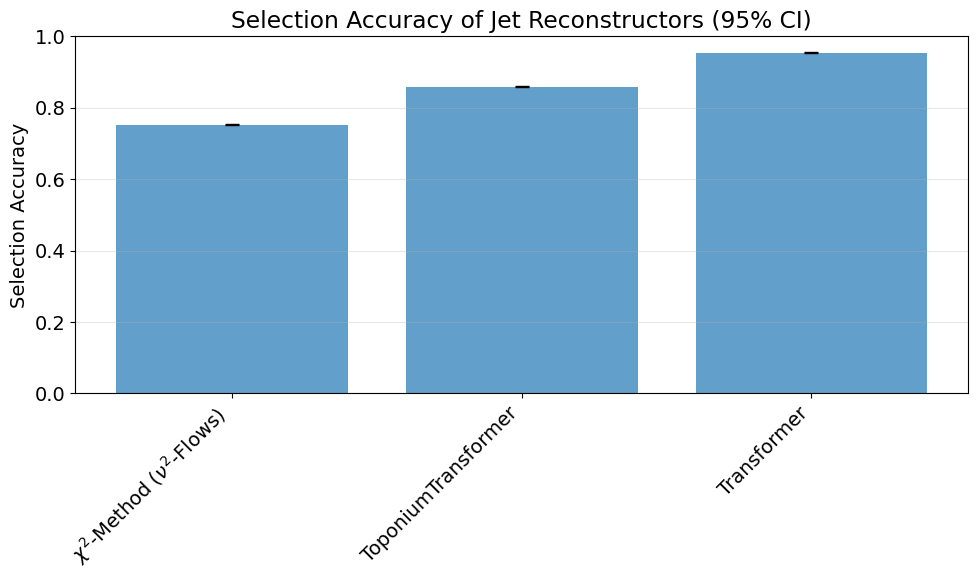

In [5]:
fig, ax = evaluator.plot_all_selection_accuracies()
fig.savefig(PLOTS_DIR + "all_selection_accuracies.pdf")


Computing binned top mass resolution for truth_ttbar_mass...


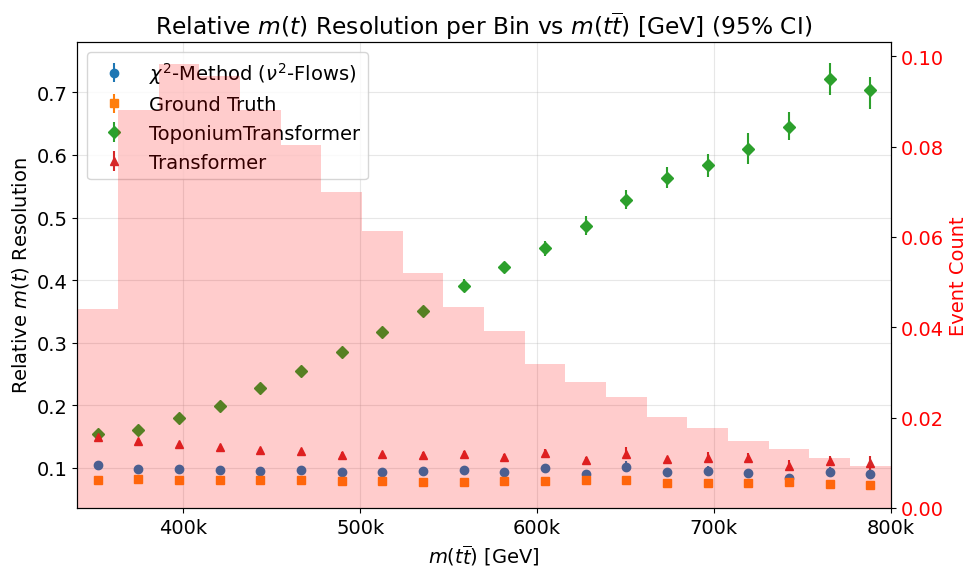

In [6]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}k" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")


Computing binned ttbar mass resolution for truth_ttbar_mass...


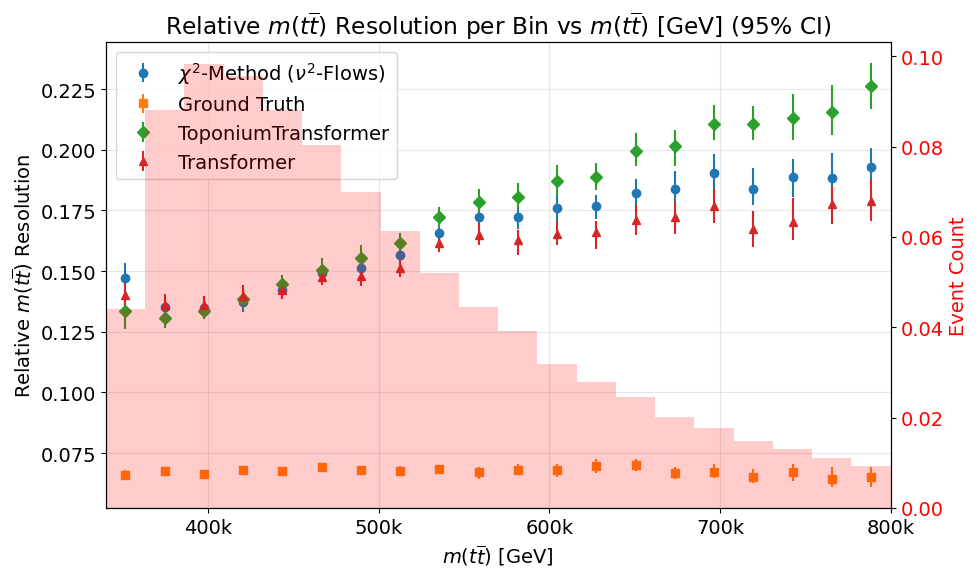

In [7]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}k" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")


Computing binned complementarity for truth_ttbar_mass...


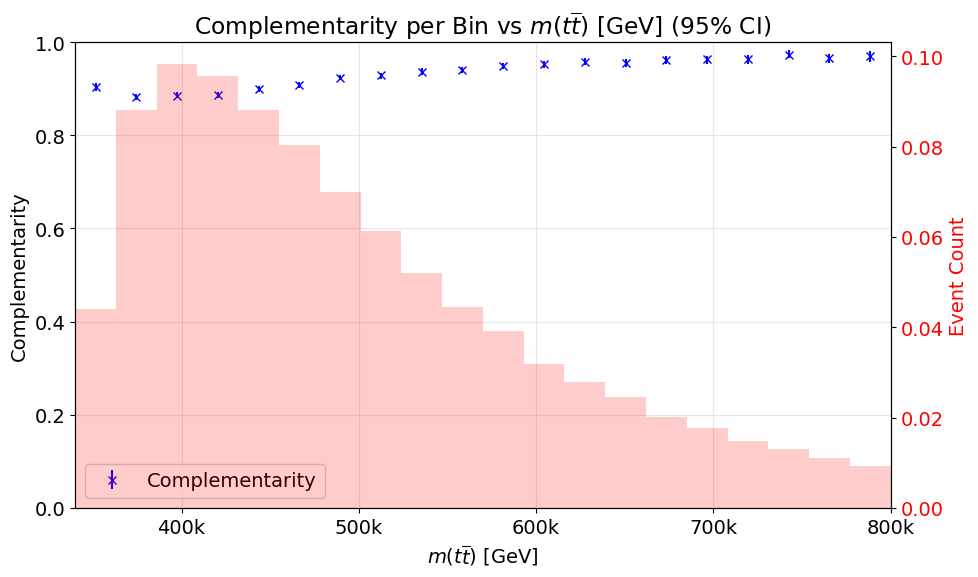

In [8]:
fig, ax = evaluator.plot_binned_complementarity(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}k" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "binned_complementarity_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_mass...


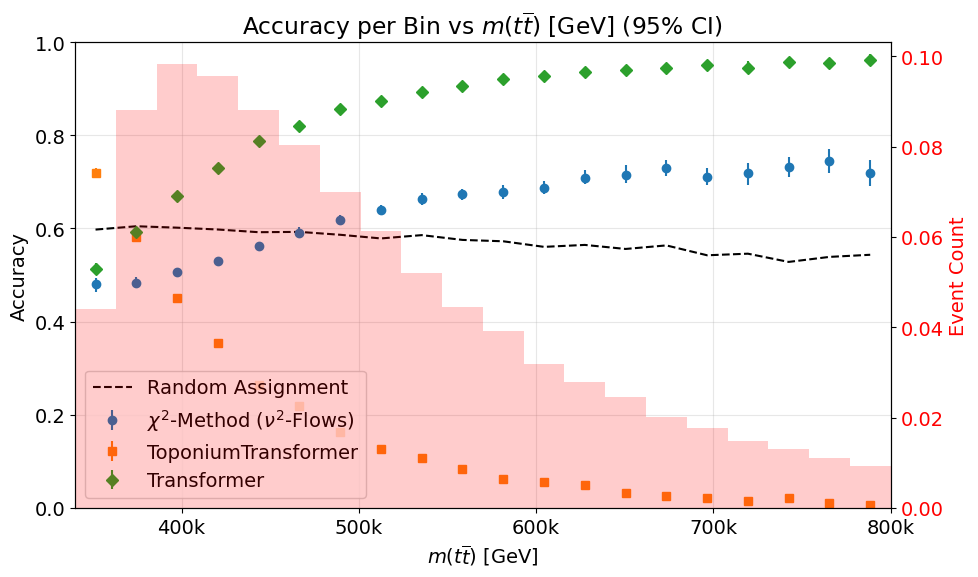

In [9]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=100,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}k" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_pt...


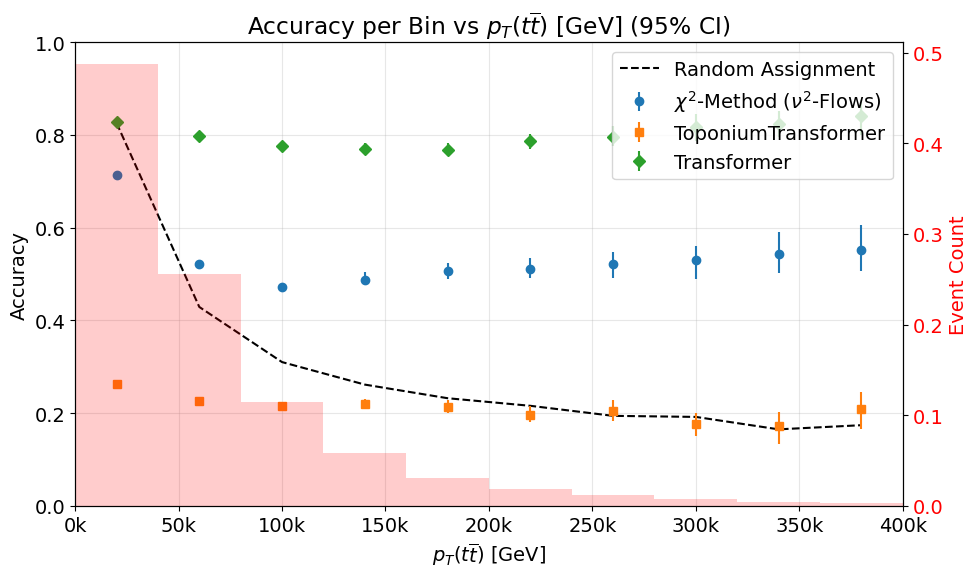

In [10]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}k" for tick in ticks])
ax.set_xlim(0, 400e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")


Computing binned accuracy for truth_initial_parton_num_gluons...


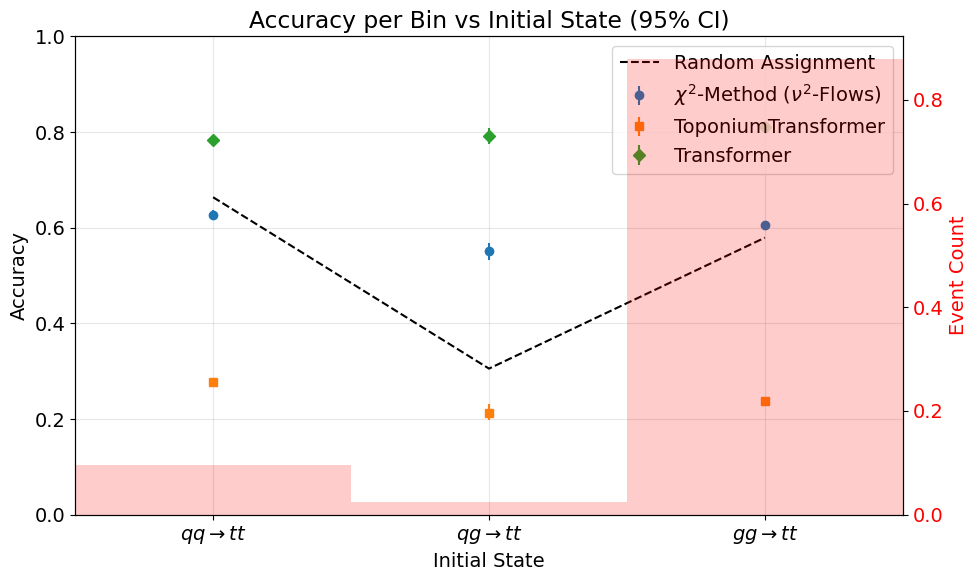

In [11]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")


Computing binned accuracy for N_jets...


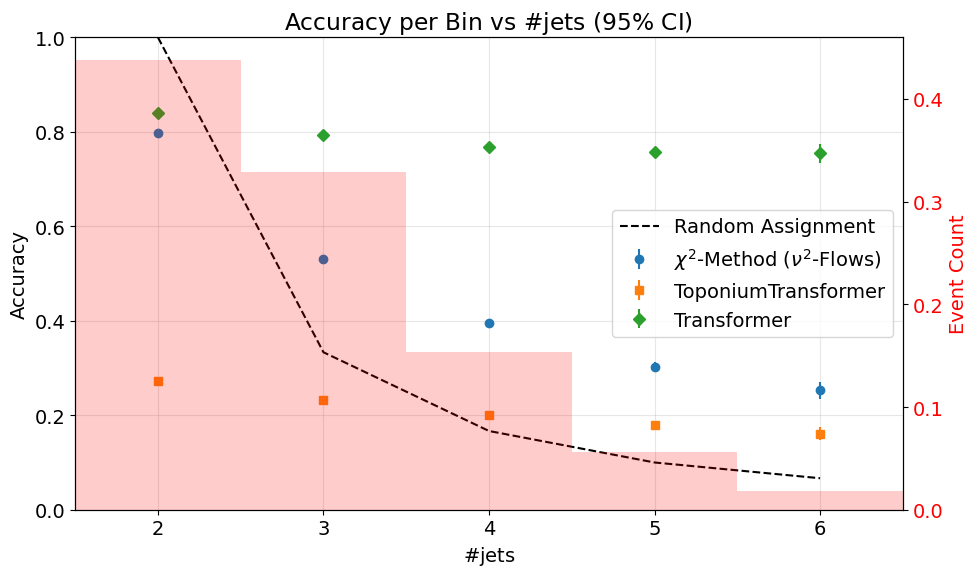

In [12]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, MAX_JETS + 1),
    bins=MAX_JETS - 1,
)
ax.set_xticks([i + 0.5 for i in range(2, MAX_JETS + 1)])
ax.set_xticklabels([i for i in range(2, MAX_JETS + 1)])
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")

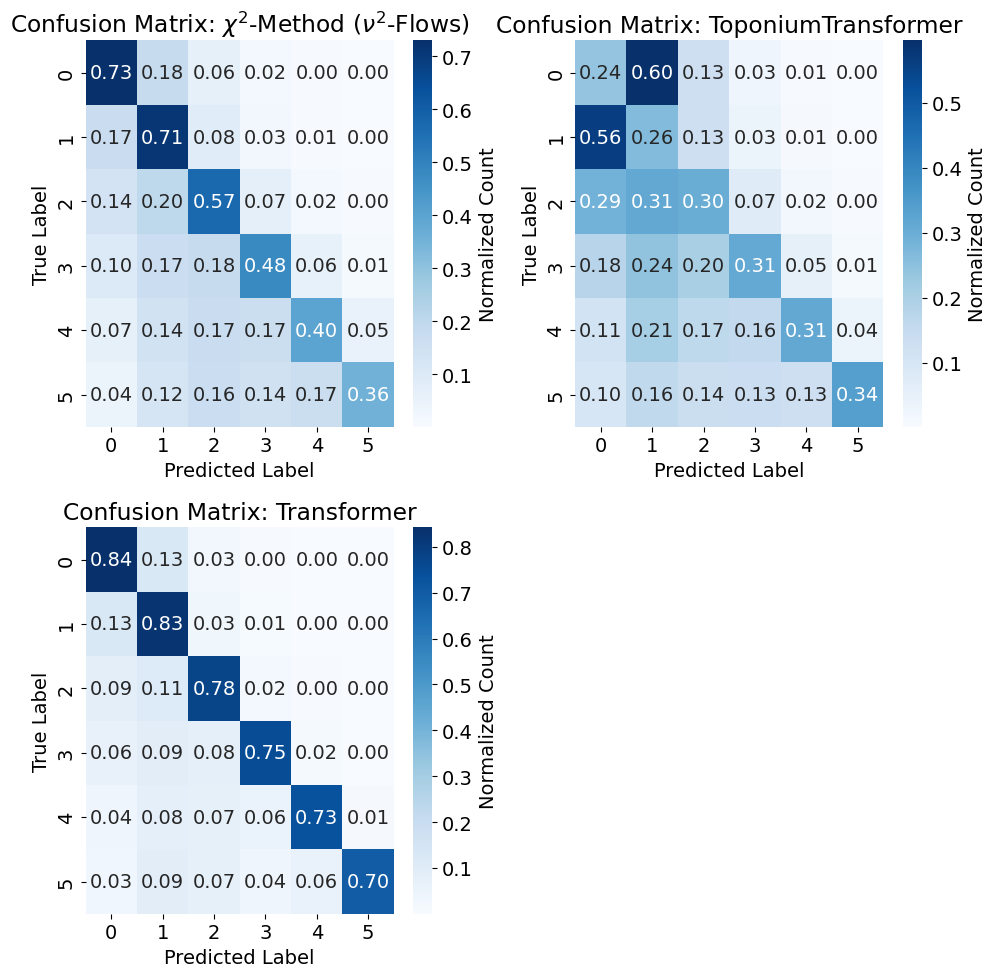

In [13]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

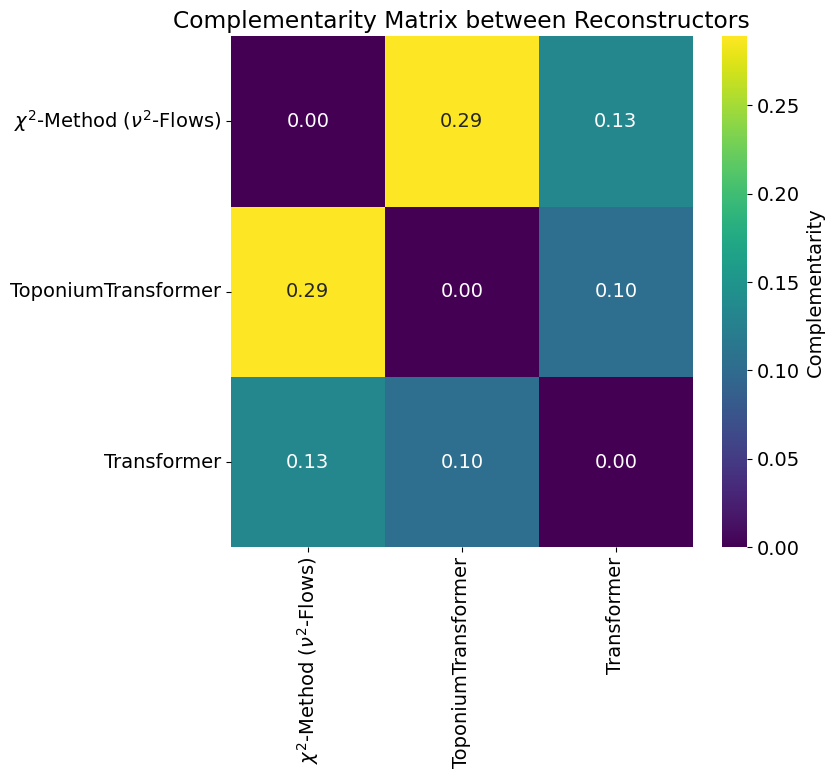

In [14]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(8.5, 8))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")